# İş Problemi (Business Problem)

Online ayakkabı mağazası olan FLO müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor.

Buna yönelik olarak müşterilerin davranışları tanımlanacak ve bu davranışlardaki öbeklenmelere göre gruplar oluşturulacak.

# Veri Seti Hikayesi

Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan)

olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

Değişkenler

- master_id : Eşsiz müşteri numarası

- order_channel : Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile)

- last_order_channel : En son alışverişin yapıldığı kanal

- first_order_date : Müşterinin yaptığı ilk alışveriş tarihi

- last_order_date : Müşterinin yaptığı son alışveriş tarihi

- last_order_date_online : Müşterinin online platformda yaptığı son alışveriş tarihi

- last_order_date_offline : Müşterinin offline platformda yaptığı son alışveriş tarihi

- order_num_total_ever_online : Müşterinin online platformda yaptığı toplam alışveriş sayısı

- order_num_total_ever_offline : Müşterinin offline'da yaptığı toplam alışveriş sayısı

- customer_value_total_ever_offline : Müşterinin offline alışverişlerinde ödediği toplam ücret

- customer_value_total_ever_online : Müşterinin online alışverişlerinde ödediği toplam ücret

- interested_in_categories_12 : Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi

# GÖREV 1: Veriyi Hazırlama
           # 1. flo_data_20K.csv.csv verisini okuyunuz.
           # 2. Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz. Tenure(Müşterinin yaşı), Recency (en son kaç gün önce alışveriş yaptığı) gibi yeni değişkenler oluşturabilirsiniz.

# GÖREV 2: K-Means ile Müşteri Segmentasyonu
           # 1. Değişkenleri standartlaştırınız.
           # 2. Optimum küme sayısını belirleyiniz.
           # 3. Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.
           # 4. Herbir segmenti istatistiksel olarak inceleyeniz.

# GÖREV 3: Hierarchical Clustering ile Müşteri Segmentasyonu
           # 1. Görev 2'de standırlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.
           # 2. Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.
           # 3. Herbir segmenti istatistiksel olarak inceleyeniz.



# Görev 1 Veriyi Hazırlama


In [2]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer  #Dirsek yöntemi için uygulanır
from sklearn.cluster import AgglomerativeClustering   #Birleştirici cluster metotu
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings("ignore")

df_ = pd.read_csv(r"flo_data_20K.csv")
df= df_.copy()

In [3]:
def checkDf(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

checkDf(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

In [4]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [6]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [7]:
df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

In [8]:
df["recency"] = (analysis_date - df["last_order_date"]).astype('timedelta64[D]') # en son kaç gün önce alışveriş yaptı
df["tenure"] = (df["last_order_date"]-df["first_order_date"]).astype('timedelta64[D]')


In [9]:
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.00,1.00,139.99,799.38,95.00,119.00
1,19.00,2.00,159.97,1853.58,105.00,1469.00
2,3.00,2.00,189.97,395.35,186.00,366.00
3,1.00,1.00,39.99,81.98,135.00,11.00
4,1.00,1.00,49.99,159.99,86.00,582.00


# Görev 2: K-Means ile Müşteri Segmentasyonu


In [10]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)
customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)
customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


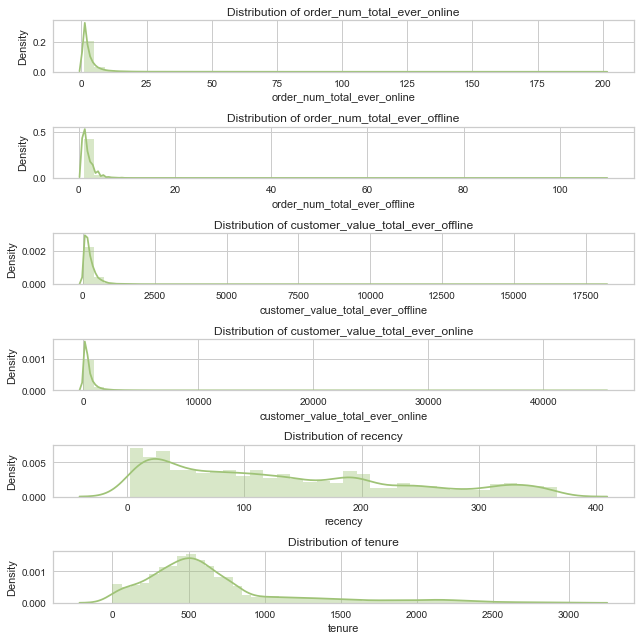

In [11]:
plt.figure(figsize=(9, 9))
plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')
plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')
plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')
plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')
plt.subplot(6, 1, 5)
check_skew(model_df,'recency')
plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)
plt.show()

In [12]:
model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline']=np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online']=np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency']=np.log1p(model_df['recency'])
model_df['tenure']=np.log1p(model_df['tenure'])
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.61,0.69,4.95,6.69,4.56,4.79
1,3.00,1.10,5.08,7.53,4.66,7.29
2,1.39,1.10,5.25,5.98,5.23,5.91
3,0.69,0.69,3.71,4.42,4.91,2.48
4,0.69,0.69,3.93,5.08,4.47,6.37


In [13]:
sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()
#model_df.describe()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.20,0.00,0.34,0.50,0.72,0.60
1,0.50,0.10,0.36,0.60,0.74,0.91
2,0.15,0.10,0.39,0.41,0.86,0.74
3,0.00,0.00,0.18,0.22,0.79,0.31
4,0.00,0.00,0.21,0.30,0.70,0.79


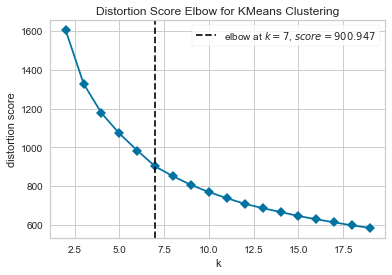

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# 2. Optimum küme sayısını belirleyiniz.
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20),timings=False)
elbow.fit(model_df)
#plt.xlim(1,3)
#plt.ylim(0.2,0.4)
elbow.show()

In [15]:
elbow.k_values_

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [16]:
elbow.k_timers_

[1.2810330390930176,
 1.980431318283081,
 0.9365415573120117,
 0.537250280380249,
 0.5122308731079102,
 0.6992073059082031,
 1.2434742450714111,
 0.7547831535339355,
 0.668936014175415,
 0.8960530757904053,
 1.2376890182495117,
 1.6972620487213135,
 1.1978282928466797,
 1.2929954528808594,
 0.8612945079803467,
 1.169905662536621,
 1.114830732345581,
 1.069805383682251]

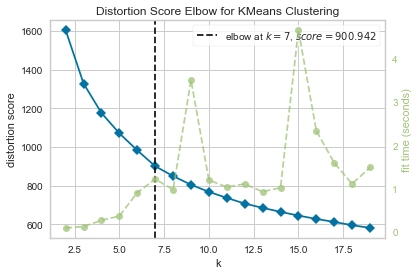

0.0860137939453125 saniyede 2 cluster fit edilmiştir.---0.0860137939453125
0.1185617446899414 saniyede 3 cluster fit edilmiştir.---0.0592808723449707
0.2609076499938965 saniyede 4 cluster fit edilmiştir.---0.08696921666463216
0.3611013889312744 saniyede 5 cluster fit edilmiştir.---0.0902753472328186
0.9037971496582031 saniyede 6 cluster fit edilmiştir.---0.18075942993164062
1.2169337272644043 saniyede 7 cluster fit edilmiştir.---0.20282228787740073
0.9741427898406982 saniyede 8 cluster fit edilmiştir.---0.13916325569152832
3.5085628032684326 saniyede 9 cluster fit edilmiştir.---0.4385703504085541
1.1941139698028564 saniyede 10 cluster fit edilmiştir.---0.13267932997809517
1.0312819480895996 saniyede 11 cluster fit edilmiştir.---0.10312819480895996
1.104311227798462 saniyede 12 cluster fit edilmiştir.---0.10039192979986017
0.9241514205932617 saniyede 13 cluster fit edilmiştir.---0.0770126183827718
1.0153608322143555 saniyede 14 cluster fit edilmiştir.---0.07810467940110427
4.66318726539

In [17]:
def timesearcher(start,end,timings=False):
    kmeans = KMeans()
    elbow = KElbowVisualizer(kmeans, k=(start,end), timings=True)
    elbow.fit(model_df)
    elbow.show()
    k_times = elbow.k_timers_
    k_values = elbow.k_values_
    for i, j in zip(k_times, k_values):
        print(f"{i} saniyede {j} cluster fit edilmiştir.---{i/(j-1)}")
    return k_times,k_values,start,end,elbow


k_times,k_values,start,end,elbow = timesearcher(2,20)



In [18]:

elbow.elbow_value_

7

In [19]:
# 3. Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.
k_means = KMeans(n_clusters = 7, random_state= 42).fit(model_df)
segments=k_means.labels_
segments

array([6, 6, 6, ..., 1, 2, 0])

In [20]:
segments[0:5]

array([6, 6, 6, 3, 4])

In [21]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head(10)

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,6
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,6
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,6
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,4
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,1.00,2.00,150.87,49.99,80.00,846.00,4
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,3.00,1.00,59.99,315.94,226.00,228.00,0
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,1.00,1.00,49.99,113.64,293.00,89.00,0
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,3.00,2.00,120.48,934.21,86.00,409.00,6
9,1143f032-440d-11ea-8b43-000d3a38a36f,1.00,1.00,69.98,95.98,240.00,432.00,0


In [22]:
final_df["segment"].value_counts()


0    5448
4    3340
2    3269
6    3245
5    1974
1    1841
3     828
Name: segment, dtype: int64

In [23]:
final_df["segment"].value_counts()

0    5448
4    3340
2    3269
6    3245
5    1974
1    1841
3     828
Name: segment, dtype: int64

In [24]:
final_df.shape


(19945, 8)

In [25]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","median","count"],
                                  "order_num_total_ever_offline":["mean","median","count"],
                                  "customer_value_total_ever_offline":["mean","median","count"],
                                  "customer_value_total_ever_online":["mean","median","count"],
                                  "recency":["mean","median","count"],
                                  "tenure":["mean","median","count"]})


order_num_total_ever_online              order_num_total_ever_offline              customer_value_total_ever_offline              customer_value_total_ever_online               recency              tenure             
                               mean median count                         mean median count                              mean median count                             mean  median count    mean median count   mean median count
segment                                                                                                                                                                                                                          
0                              1.42   1.00  5448                         1.28   1.00  5448                            145.16 120.74  5448                           210.07  179.98  5448  225.71 211.00  5448 489.85 393.00  5448
1                              2.20   2.00  1841                         2.10   2.00  1841                            293.82 209.98  1841                           377.70  297.96  1841   10.00  10.00  1841 665.01 600.00  1841
2                              1.84   1.00  3269                         3.77   3.00  3269                            551.78 449.96  3269                           283.36  222.48  3269  153.29 132.00  3269 729.95 578.00  3269
3                              1.40   1.00   828                         1.13   1.00   828                            192.39 149.99   828                           250.37  179.99   828  139.55 113.00   828  37.24  32.00   828
4                              1.61   1.00  3340                         1.48   1.00  3340                            185.84 149.99  3340                           250.00  206.72  3340   50.33  47.00  3340 604.52 546.00  3340
5                              8.63   6.00  1974                         2.10   2.00  1974                            278.89 200.24  1974                          1475.52 1065.21  1974   32.72  29.00  1974 966.63 752.00  1974
6                              6.37   5.00  3245                         1.54   1.00  3245                            184.41 140.87  3245                           985.51  779.54  3245  180.09 169.00  3245 943.90 714.00  3245

In [26]:
#Ekstra olarak buradan elde ettiğim faydalı bilgiyi müşteriler ile iletişme geçen ya da kampanya hazırlayan departmana iletmek istersem;
segment_6_musterilerim = final_df[final_df["segment"]== 6]
departmana_gidecek = pd.merge(segment_6_musterilerim,df,how='inner')
departmana_gidecek.to_csv("departmanagidecek.csv", index=False)
departmana_gidecek.shape

(3245, 15)

GÖREV 3: Hierarchical Clustering ile Müşteri Segmentasyonu


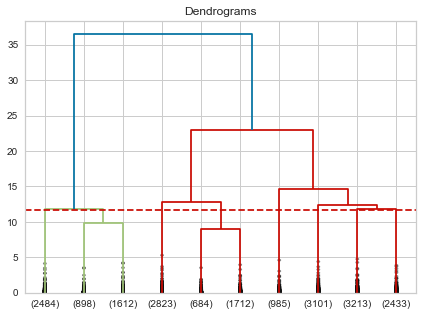

In [27]:
# 1. Görev 2'de standarlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.
hc_complete = linkage(model_df, 'ward')
plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=11.70, color='r', linestyle='--')
plt.show()

In [28]:
# 2. Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.
hc = AgglomerativeClustering(n_clusters=6)
segments = hc.fit_predict(model_df)

final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,5


In [29]:
final_df["segment"].value_counts()

1    5646
0    4994
5    3101
4    2823
2    2396
3     985
Name: segment, dtype: int64

In [30]:
# 3. Herbir segmenti istatistiksel olarak inceleyeniz.
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","median","count"],
                                  "order_num_total_ever_offline":["mean","median","count"],
                                  "customer_value_total_ever_offline":["mean","median","count"],
                                  "customer_value_total_ever_online":["mean","median","count"],
                                  "recency":["mean","median","count"],
                                  "tenure":["mean","median","count"]})


order_num_total_ever_online              order_num_total_ever_offline              customer_value_total_ever_offline              customer_value_total_ever_online              recency              tenure             
                               mean median count                         mean median count                              mean median count                             mean median count    mean median count   mean median count
segment                                                                                                                                                                                                                         
0                              3.75   2.00  4994                         1.82   1.00  4994                            240.98 165.97  4994                           638.61 407.96  4994   23.96  22.00  4994 715.07 608.00  4994
1                              1.40   1.00  5646                         2.19   2.00  5646                            293.63 200.48  5646                           222.68 179.97  5646  229.93 224.00  5646 501.81 405.50  5646
2                              6.91   5.00  2396                         3.08   3.00  2396                            427.12 352.30  2396                          1104.12 745.43  2396  131.57 110.00  2396 914.49 682.00  2396
3                              1.40   1.00   985                         1.20   1.00   985                            200.69 160.97   985                           227.42 181.30   985   92.52  73.00   985  80.26  51.00   985
4                              4.74   4.00  2823                         1.12   1.00  2823                            123.46  99.99  2823                           722.77 591.43  2823  196.52 188.00  2823 876.95 650.00  2823
5                              1.32   1.00  3101                         1.61   1.00  3101                            204.32 156.97  3101                           181.46 149.99  3101   97.64  92.00  3101 693.37 548.00  3101